In [3]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import sys
sys.path.append("..")

from src.statistics import bin_stats


Im going to try binning by wave period and doing my analysis in that way for a moment. 

As a refresher. The bin_stats script does the following
- removes and nan values
- creates bins of chosen bin_col parameter with specified bin_size
- for every agg_col, it calculates mean, SEM, std
- deletes any bines fewer than 5 (or chosen min_points)


In [4]:
bulk_df = pd.read_parquet('../data_interim/bulk_df.parquet')
binned_H0 = bin_stats(
    bulk_df, 
    bin_col='H0', 
    # Add the new columns to this list
    agg_cols=['H0', 'L0', 'H0L0', 'Tp', 'setup', 'Hs_IG_Nearshore'], 
    bin_size=1.   
)
binned_Tp = bin_stats(
    bulk_df, 
    bin_col='Tp', 
    # Add the new columns to this list
    agg_cols=['H0', 'L0', 'H0L0', 'steepness', 'setup', 'Hs_IG_Nearshore'], 
    bin_size=1.   
)

binned_H0.keys()

Index(['H0_mean', 'H0_std', 'H0_count', 'L0_mean', 'L0_std', 'L0_count',
       'H0L0_mean', 'H0L0_std', 'H0L0_count', 'Tp_mean', 'Tp_std', 'Tp_count',
       'setup_mean', 'setup_std', 'setup_count', 'Hs_IG_Nearshore_mean',
       'Hs_IG_Nearshore_std', 'Hs_IG_Nearshore_count', 'bin_center', 'H0_sem',
       'L0_sem', 'H0L0_sem', 'Tp_sem', 'setup_sem', 'Hs_IG_Nearshore_sem'],
      dtype='object')

/var/folders/7q/04p1sn755vg5x39skt2hykjh0000gn/T/ipykernel_15601/1468068692.py:22: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


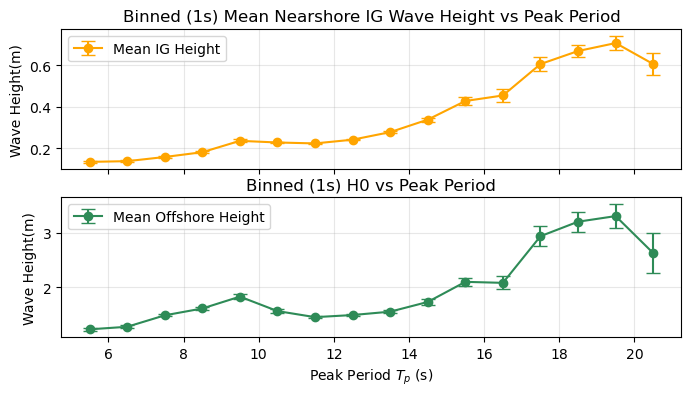

In [5]:
fig, ax = plt.subplots(2, figsize=(8, 4), sharex=True)


# Plotting the mean values
ax[0].errorbar(binned_Tp['bin_center'], binned_Tp['Hs_IG_Nearshore_mean'], 
             yerr=binned_Tp['Hs_IG_Nearshore_sem'], fmt='o-', capsize=5, label='Mean IG Height', color='orange')

#ax[0].axvline(x=12.0, color='red', linestyle='--', alpha=0.7, label='Regime shift? (Tp=12s)')
ax[0].set_ylabel('Wave Height(m)')
ax[0].set_title('Binned (1s) Mean Nearshore IG Wave Height vs Peak Period')
ax[0].grid(True, alpha=0.3)
ax[0].legend()

ax[1].errorbar(binned_Tp['bin_center'], binned_Tp['H0_mean'], 
             yerr=binned_Tp['H0_sem'], fmt='o-', capsize=5, label='Mean Offshore Height', color='seagreen')
ax[1].set_title('Binned (1s) H0 vs Peak Period')
ax[1].set_xlabel('Peak Period $T_p$ (s)')
ax[1].set_ylabel('Wave Height(m)')
ax[1].grid(True, alpha=0.3)
ax[1].legend()

fig.show()

In [7]:
wind_sea_raw

,H0,n,h_tide,L0,H0/L0,H0L0,steepness,Tp,Hs_IG_Nearshore,setdown_x,setup,H6,setdown_y,setdown
time,,,,,,,,,,,,,,
2007-12-14 20:30:01.133175807,1.561702,-0.058058,0.135974,63.574211,0.024565,99.283985,0.024565,7.258096,0.179314,-7.389572e-08,-0.058058,1.426781,-7.389572e-08,-7.389572e-08
2007-12-15 01:00:01.203678207,1.478285,-0.032914,-0.018295,59.721863,0.024753,88.285943,0.024753,8.181854,0.148246,-9.628975e-08,-0.032914,1.366635,-9.628975e-08,-9.628975e-08
2007-12-15 01:45:01.215428607,1.988919,-0.103069,-0.024801,65.259856,0.030477,129.796562,0.030477,7.438049,0.153863,-1.112810e-07,-0.103069,1.818840,-1.112810e-07,-1.112810e-07
2007-12-15 02:00:01.219345407,1.806225,-0.049527,-0.027733,58.641377,0.030801,105.919532,0.030801,7.531414,0.155878,-1.266231e-07,-0.049527,1.652022,-1.266231e-07,-1.266231e-07
2007-12-15 02:30:01.227179007,1.684570,-0.043414,-0.035546,64.227174,0.026228,108.195180,0.026228,7.627152,0.141834,-1.050492e-07,-0.043415,1.544952,-1.050492e-07,-1.050492e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-01-17 05:00:13.674769408,2.107608,0.074125,-0.094064,149.694696,0.014079,315.497722,0.014079,10.843421,0.395082,-1.765315e-07,0.074124,2.085123,-1.765315e-07,-1.765315e-07
2008-01-17 16:15:13.851025407,1.911516,0.095532,-0.058875,132.183839,0.014461,252.671531,0.014461,10.909138,0.318636,-9.287017e-08,0.095532,1.873946,-9.287017e-08,-9.287017e-08
2008-01-17 19:00:13.894110207,1.460060,0.111423,-0.169360,128.223051,0.011387,187.213293,0.011387,10.285759,0.291697,-4.024547e-08,0.111423,1.420511,-4.024547e-08,-4.024547e-08


In [9]:
# compute H0Tp and H0^2Tp
bulk_df['H0_Tp_product'] = bulk_df['H0'] * bulk_df['Tp']
bulk_df['H02_Tp'] = bulk_df['H0_Tp_product'] * bulk_df['H0']

# Split the raw data
wind_sea_raw = bulk_df[bulk_df['Tp'] <= 11]
swell_raw = bulk_df[bulk_df['Tp'] >= 11]

# Compare correlations for Wind Sea (< 11.5s)
tp_corr_low = wind_sea_raw['Tp'].corr(wind_sea_raw['Hs_IG_Nearshore'], method='pearson')
h0_corr_low = wind_sea_raw['H0'].corr(wind_sea_raw['Hs_IG_Nearshore'], method='pearson')
H0_Tp_low = wind_sea_raw['H0_Tp_product'].corr(wind_sea_raw['Hs_IG_Nearshore'], method='pearson')
H02_Tp_low = wind_sea_raw['H02_Tp'].corr(wind_sea_raw['Hs_IG_Nearshore'], method='pearson')


# Compare correlations for Swell (>= 11.5s)
tp_corr_high = swell_raw['Tp'].corr(swell_raw['Hs_IG_Nearshore'], method='pearson')
h0_corr_high = swell_raw['H0'].corr(swell_raw['Hs_IG_Nearshore'], method='pearson')
H0_Tp_high = swell_raw['H0_Tp_product'].corr(swell_raw['Hs_IG_Nearshore'], method='pearson')
H02_Tp_high = swell_raw['H02_Tp'].corr(swell_raw['Hs_IG_Nearshore'], method='pearson')


print(f"--- Wind Sea (Tp < 11.5s) ---")
print(f"Correlation with Tp: {tp_corr_low:.3f}")
print(f"Correlation with H0: {h0_corr_low:.3f}")
print(f"Correlation with (H0 * Tp): {H0_Tp_low:.3f}")
print(f"Correlation with (H0^2 * Tp): {H02_Tp_low:.3f}")


print(f"\n--- Swell (Tp >= 11.5s) ---")
print(f"Correlation with Tp: {tp_corr_high:.3f}")
print(f"Correlation with H0: {h0_corr_high:.3f}")
print(f"Correlation with (H0 * Tp): {H0_Tp_high:.3f}")
print(f"Correlation with (H0^2 * Tp): {H02_Tp_high:.3f}")



--- Wind Sea (Tp < 11.5s) ---
Correlation with Tp: 0.361
Correlation with H0: 0.855
Correlation with (H0 * Tp): 0.902
Correlation with (H0^2 * Tp): 0.893

--- Swell (Tp >= 11.5s) ---
Correlation with Tp: 0.581
Correlation with H0: 0.901
Correlation with (H0 * Tp): 0.914
Correlation with (H0^2 * Tp): 0.824


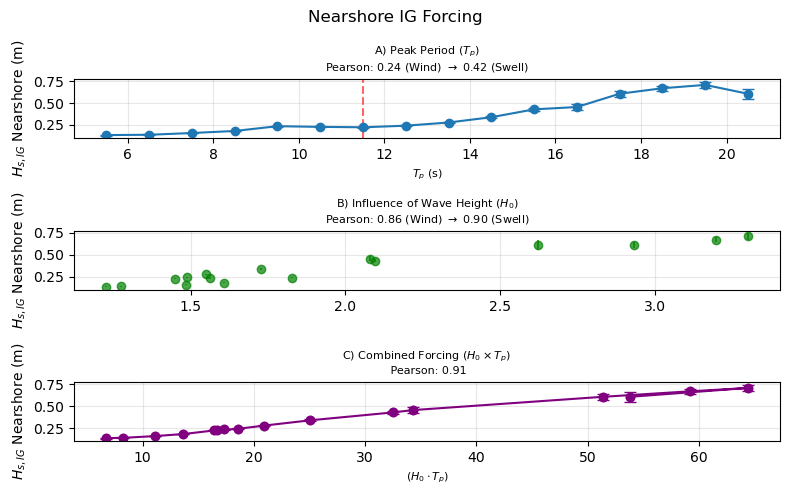

In [10]:
import matplotlib.pyplot as plt

axfont = 8

# We can approximate the binned product by multiplying the means
binned_Tp['H0Tp_mean'] = binned_Tp['H0_mean'] * binned_Tp['bin_center']

fig, ax = plt.subplots(3, 1, figsize=(8 , 5), sharey=True)
plt.subplots_adjust(hspace=0.4)

# Plot 1: Tp vs Hs_IG (The "Threshold" Plot)
ax[0].errorbar(binned_Tp['bin_center'], binned_Tp['Hs_IG_Nearshore_mean'], 
               yerr=binned_Tp['Hs_IG_Nearshore_sem'], fmt='o-', capsize=4, label='Data')
ax[0].axvline(11.5, color='red', linestyle='--', alpha=0.6, label='Swell Threshold (11.5s)')
ax[0].set_title('A) Peak Period ($T_p$)\nPearson: 0.24 (Wind) $\\rightarrow$ 0.42 (Swell)', fontsize=axfont)
ax[0].set_xlabel('$T_p$ (s)', fontsize=axfont)

# Plot 2: Scatter instead of line to avoid "zigzag"
ax[1].errorbar(binned_Tp['H0_mean'], binned_Tp['Hs_IG_Nearshore_mean'], 
               yerr=binned_Tp['Hs_IG_Nearshore_sem'], fmt='o', color='green', alpha=0.7)
ax[1].set_title('B) Influence of Wave Height ($H_0$)\nPearson: 0.86 (Wind) $\\rightarrow$ 0.90 (Swell)', fontsize=axfont)

# Plot 3: Scatter 
x = binned_Tp['H0Tp_mean']
y = binned_Tp['Hs_IG_Nearshore_mean']
ax[2].errorbar(x, y, yerr=binned_Tp['Hs_IG_Nearshore_sem'], fmt='o', color='purple', alpha=0.7)
ax[2].set_title('C) Combined Forcing ($H_0 \\times T_p$)\nPearson: 0.90 (Wind) $\\rightarrow$ 0.91 (Swell)', fontsize=axfont)



# Plot 3: H0*Tp vs Hs_IG (The "Predictor" Plot)
ax[2].errorbar(binned_Tp['H0Tp_mean'], binned_Tp['Hs_IG_Nearshore_mean'], 
               yerr=binned_Tp['Hs_IG_Nearshore_sem'], fmt='o-', color='purple', capsize=4)
ax[2].set_title('C) Combined Forcing ($H_0 \\times T_p$) \n Pearson: 0.91', fontsize=axfont)
ax[2].set_xlabel('($H_0 \\cdot T_p$)', fontsize=axfont)

# Global styling
for a in ax:
    a.set_ylabel('$H_{s,IG}$ Nearshore (m)')
    a.grid(True, alpha=0.3)

fig.suptitle('Nearshore IG Forcing')
plt.tight_layout()
plt.show()


In [11]:
# Create the combined parameter in the raw data
bulk_df['H0_Tp_product'] = bulk_df['H0'] * bulk_df['Tp']

# Re-split to get the new column in the swell regime
swell_raw = bulk_df[bulk_df['Tp'] >= 11.5]
wind_raw = bulk_df[bulk_df['Tp'] <= 11.5]


# Calculate the new correlation
product_corr_w = wind_raw['H0_Tp_product'].corr(wind_raw['Hs_IG_Nearshore'], method='pearson')

product_corr = swell_raw['H0_Tp_product'].corr(swell_raw['Hs_IG_Nearshore'], method='pearson')

print(f"Correlation with (H0 * Tp) [Tp >= 11.5s]: {product_corr:.3f}")
print(f"Correlation with (H0 * Tp) [Tp <= 11.5s]: {product_corr_w:.3f}")

Correlation with (H0 * Tp) [Tp >= 11.5s]: 0.913
Correlation with (H0 * Tp) [Tp <= 11.5s]: 0.896


In [12]:
over_12 = binned_Tp[binned_Tp.index >= 12]

pearson = bulk_df[bulk_df['Tp'] > 12.0]['Tp'].corr(bulk_df[bulk_df['Tp'] > 12.0]['Hs_IG_Nearshore'], method='pearson')

print(f"Pearson Correlation: {pearson:.2f}")

Pearson Correlation: 0.58


In [13]:
# Correlation on the raw data
pearson = bulk_df[bulk_df['Tp'] > 12.0]['Tp'].corr(bulk_df[bulk_df['Tp'] > 12.0]['Hs_IG_Nearshore'], method='pearson')

print(f"Pearson Correlation: {pearson:.2f}")


Pearson Correlation: 0.58


In [14]:
# Create the Energy-Period parameter
bulk_df['H02_Tp'] = (bulk_df['H0']**2) * bulk_df['Tp']

# Re-split for swell
swell_raw = bulk_df[bulk_df['Tp'] >= 11.5]

# Calculate Spearman Correlation
energy_corr = swell_raw['H02_Tp'].corr(swell_raw['Hs_IG_Nearshore'], method='spearman')

print(f"Correlation with (H0^2 * Tp) [Tp >= 11.5s]: {energy_corr:.3f}")

Correlation with (H0^2 * Tp) [Tp >= 11.5s]: 0.919


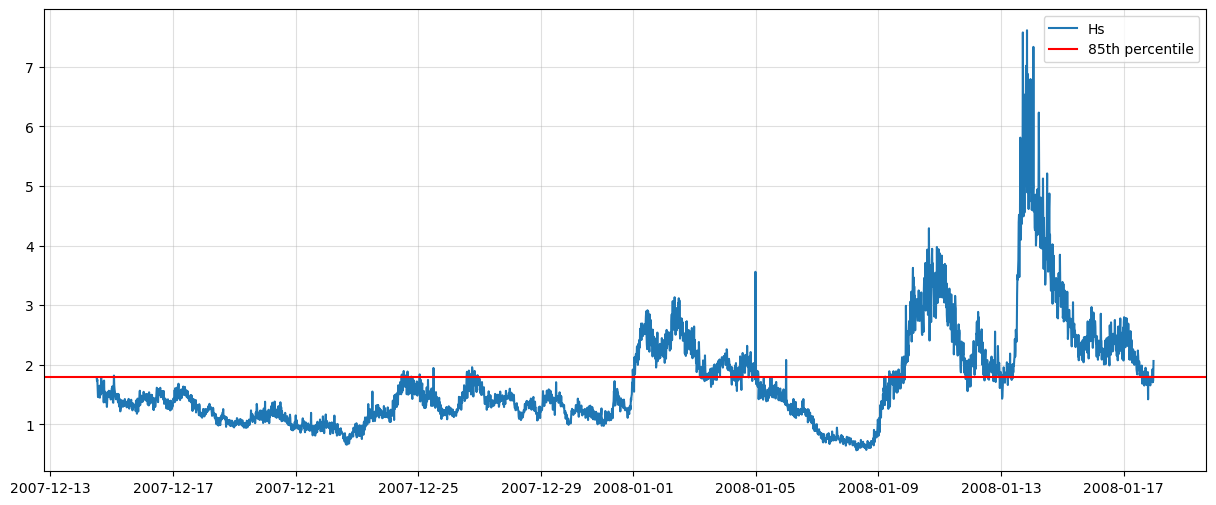

In [15]:
p66 = np.percentile(bulk_df['H6'], 66)

plt.figure(figsize=(15,6))
plt.plot(bulk_df.index,bulk_df['H6'], label='Hs')
plt.axhline(p66, color='r', linestyle='-', label='85th percentile')
plt.grid(True, alpha=0.4)
plt.legend()

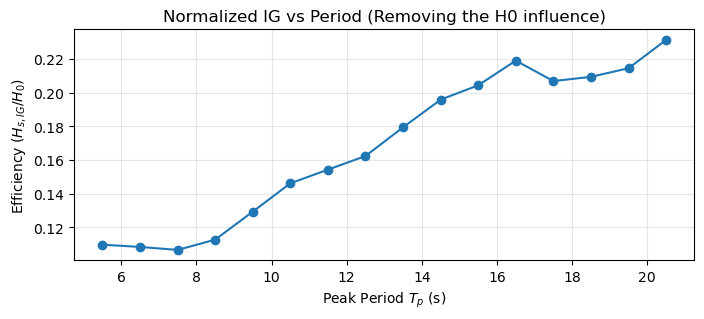

In [16]:
# Calculate the 'Efficiency' of IG generation using binned data
binned_Tp['IG_efficiency'] = binned_Tp['Hs_IG_Nearshore_mean'] / binned_Tp['H0_mean']

# Plot it
plt.figure(figsize=(8, 3))
plt.plot(binned_Tp['bin_center'], binned_Tp['IG_efficiency'], 'o-')
plt.ylabel('Efficiency ($H_{s,IG} / H_0$)')
plt.xlabel('Peak Period $T_p$ (s)')
plt.title('Normalized IG vs Period (Removing the H0 influence)')
plt.grid(True,alpha=0.3)
plt.show()

By defining this non dimensional parameter, I am seeing that there is indeed a correlation between period and IG without H0 influence since $Hs_{IG}$ has been normalized. 

However, the plot above was performed on the binned data. Going to try with the raw data (bulk_df)

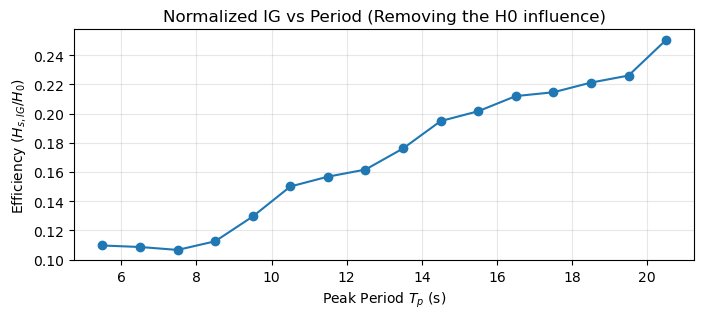

Correlation with Transfer Eff.: 0.92


In [17]:
# using raw data
bulk_df['transfer_efficiency'] = bulk_df['Hs_IG_Nearshore'] / bulk_df['H0']

binned_Tp = bin_stats(
    bulk_df, 
    bin_col='Tp', 
    # Add the new columns to this list
    agg_cols=['H0', 'L0', 'H0L0', 'steepness', 'setup', 'Hs_IG_Nearshore', 'transfer_efficiency'], 
    bin_size=1.   
)

plt.figure(figsize=(8, 3))
plt.plot(binned_Tp['bin_center'], binned_Tp['transfer_efficiency_mean'], 'o-')
plt.ylabel('Efficiency ($H_{s,IG} / H_0$)')
plt.xlabel('Peak Period $T_p$ (s)')
plt.title('Normalized IG vs Period (Removing the H0 influence)')
plt.grid(True,alpha=0.3)
plt.show()


corr_te = binned_Tp['transfer_efficiency_mean'].corr(binned_Tp['Hs_IG_Nearshore_mean'], method='pearson')
print(f"Correlation with Transfer Eff.: {corr_te:.2f}")


Doing correlation analysis but seperating out at 9s mark which is where the figure starts to go from flat to slope

In [18]:
# 1. Split the binned data at the new 9s efficiency threshold
low_tp_binned = binned_Tp[binned_Tp['bin_center'] < 9]
high_tp_binned = binned_Tp[binned_Tp['bin_center'] >= 9]

# 2. Correlation: Efficiency vs IG Height (as per your snippet)
corr_te_ig_low = low_tp_binned['transfer_efficiency_mean'].corr(low_tp_binned['Hs_IG_Nearshore_mean'])
corr_te_ig_high = high_tp_binned['transfer_efficiency_mean'].corr(high_tp_binned['Hs_IG_Nearshore_mean'])

# 3. Correlation: Tp vs Efficiency (This quantifies the "slope" you see)
corr_slope_low = low_tp_binned['bin_center'].corr(low_tp_binned['transfer_efficiency_mean'])
corr_slope_high = high_tp_binned['bin_center'].corr(high_tp_binned['transfer_efficiency_mean'])

print(f"--- Wind Regime (Tp < 9s) ---")
print(f"TE vs IG Height Corr: {corr_te_ig_low:.3f}")
print(f"Tp vs Efficiency Corr (Slope): {corr_slope_low:.3f}")

print(f"\n--- Swell Regime (Tp >= 9s) ---")
print(f"TE vs IG Height Corr: {corr_te_ig_high:.3f}")
print(f"Tp vs Efficiency Corr (Slope): {corr_slope_high:.3f}")

--- Wind Regime (Tp < 9s) ---
TE vs IG Height Corr: 0.513
Tp vs Efficiency Corr (Slope): 0.348

--- Swell Regime (Tp >= 9s) ---
TE vs IG Height Corr: 0.896
Tp vs Efficiency Corr (Slope): 0.987


In [21]:
swell_event

,H0,n,h_tide,L0,H0/L0,H0L0,steepness,Tp,Hs_IG_Nearshore,setdown_x,setup,H6,setdown_y,setdown,H0_Tp_product,H02_Tp,transfer_efficiency,setup_efficiency
time,,,,,,,,,,,,,,,,,,
2007-12-14 12:15:01.003921408,1.645071,-0.029936,0.173463,91.624145,0.017955,150.728218,0.017955,14.634210,0.196278,-8.612608e-08,0.140939,1.786121,-8.612608e-08,-8.612608e-08,24.074314,39.603954,0.119313,0.085673
2007-12-14 12:30:01.007838208,1.626725,-0.078732,0.197391,82.591279,0.019696,134.353266,0.019696,13.846214,0.209341,-6.321125e-08,0.092143,1.726074,-6.321125e-08,-6.321125e-08,22.523977,36.640308,0.128688,0.056643
2007-12-14 12:45:01.011755007,1.635449,-0.077717,0.220038,88.654160,0.018448,144.989335,0.018448,14.173290,0.210029,-6.381081e-08,0.093158,1.752083,-6.381081e-08,-6.381081e-08,23.179690,37.909194,0.128423,0.056962
2007-12-14 13:00:01.015671808,1.512499,-0.017358,0.241270,76.812256,0.019691,116.178469,0.019691,13.333391,0.205247,-9.041383e-08,0.153517,1.579092,-9.041383e-08,-9.041383e-08,20.166743,30.502181,0.135701,0.101499
2007-12-14 13:15:01.019588608,1.383515,-0.035062,0.260961,69.346901,0.019951,95.942475,0.019951,13.740518,0.168462,-8.536625e-08,0.135813,1.463238,-8.536625e-08,-8.536625e-08,19.010212,26.300913,0.121764,0.098165
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2008-01-17 22:15:13.945028607,1.636291,0.074588,-0.382151,140.963989,0.011608,230.658171,0.011608,12.676112,0.256726,-7.538904e-08,0.245463,1.705907,-7.538904e-08,-7.538904e-08,20.741813,33.939651,0.156895,0.150012
2008-01-17 22:30:13.948945407,1.836326,0.065204,-0.398928,136.162355,0.013486,250.038532,0.013486,13.333391,0.227943,-7.189168e-08,0.236079,1.926385,-7.189168e-08,-7.189168e-08,24.484459,44.961460,0.124130,0.128560
2008-01-17 22:45:13.952862207,1.638650,0.045569,-0.414873,128.485516,0.012754,210.542782,0.012754,12.949697,0.248969,-7.355116e-08,0.216444,1.709467,-7.355116e-08,-7.355116e-08,21.220019,34.772183,0.151936,0.132087


#### Swell event analysis


<>:35: SyntaxWarning: invalid escape sequence '\e'
<>:35: SyntaxWarning: invalid escape sequence '\e'
/var/folders/7q/04p1sn755vg5x39skt2hykjh0000gn/T/ipykernel_15601/1875841665.py:35: SyntaxWarning: invalid escape sequence '\e'
  ax1.set_title(f'A) Nearshore Setup Efficiency $\eta / H_0$', loc='left', fontweight='bold')
/var/folders/7q/04p1sn755vg5x39skt2hykjh0000gn/T/ipykernel_15601/1875841665.py:35: SyntaxWarning: invalid escape sequence '\e'
  ax1.set_title(f'A) Nearshore Setup Efficiency $\eta / H_0$', loc='left', fontweight='bold')


ValueError: not enough values to unpack (expected 4, got 2)

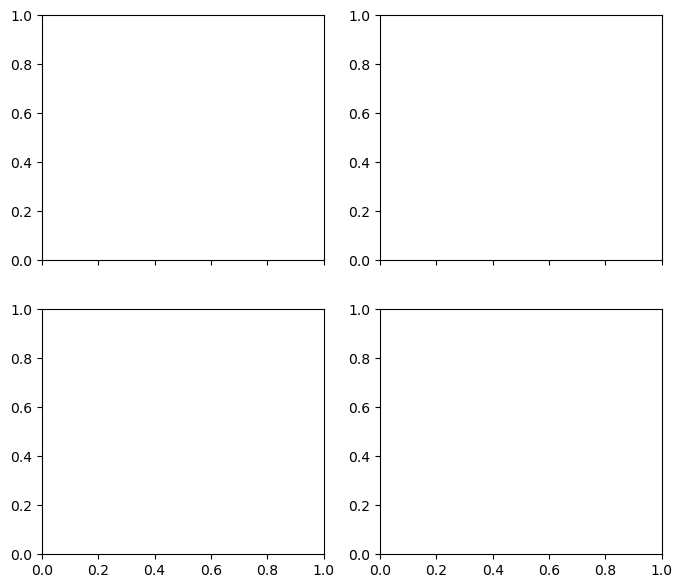

In [35]:
# create new df so i dont mess with bulk_df
swell_event = bulk_df.copy()
# offset setup so min value is 0
swell_event['setup'] = swell_event['setup'] - swell_event['setup'].min()
# compute setup efficiency [setup / H0]
swell_event['setup_efficiency'] =  swell_event['setup'] / swell_event['H0']

# Create smoothed versions (window=24 might represent 24 hours if data is hourly)
window_size = 4 # 1 hr

swell_event['setup_smooth'] = swell_event['setup_efficiency'].rolling(window=window_size, center=True).mean()
swell_event['transfer_smooth'] = swell_event['transfer_efficiency'].rolling(window=window_size, center=True).mean()




# plot
import matplotlib.pyplot as plt
import numpy as np

fig, (ax1, ax2, ax3, ax4) = plt.subplots(2, 2, figsize=(8, 7), sharex=True)

# Setup Efficiency
ax1.plot(swell_event.index, swell_event['setup_efficiency'], 
         color='teal', lw=0.5, alpha=0.3) # Faded raw data
ax1.plot(swell_event.index, swell_event['setup_smooth'], 
         color='teal', lw=2, label='1 hr Rolling Mean') # Smooth trend
setup_mean = swell_event['setup_efficiency'].mean()

ax1.axhline(swell_event['setup_efficiency'].mean(), color='firebrick', 
            ls='--', lw=1, label=f"Mean ({swell_event['setup_efficiency'].mean():.2f})")


ax1.set_ylabel(r'Efficiency [$\eta / H_0$]')
ax1.set_title(f'A) Nearshore Setup Efficiency $\eta / H_0$', loc='left', fontweight='bold')

# --- PANEL 2: Peak Period (The "Modulator") ---
ax2.plot(swell_event.index, swell_event['transfer_efficiency'], 
         color='royalblue', lw=0.5, alpha=0.3) # Faded raw data
ax2.plot(swell_event.index, swell_event['transfer_smooth'], 
         color='royalblue', lw=2)
ax2.set_ylabel('Transfer Efficiency $H_{1,IG} / H_0$')
ax2.set_title('B) Transfer Efficiency ($H_{1,IG} / H_0$)', loc='left', fontweight='bold')

# --- PANEL 3: Wave Height  ---
ax3.fill_between(swell_event.index, swell_event['H0'], color='slategray', alpha=0.15)
ax3.plot(swell_event.index, swell_event['H0'], color='darkslategrey', lw=1.2)
ax3.set_ylabel('$H_0$ [m]')
ax3.set_title('C) Offshore Wave Height', loc='left', fontweight='bold')

# ---- PANEL 4: peak period ---
ax4.plot(swell_event.index, swell_event['Tp'])

# --- Global Refinement ---
for ax in [ax1, ax2, ax3, ax4]:
    ax.grid(True, linestyle='-', alpha=0.2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(frameon=False, loc='upper left', fontsize=8)

# Format Dates
ax3.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()




/var/folders/7q/04p1sn755vg5x39skt2hykjh0000gn/T/ipykernel_15601/1706450262.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(frameon=False, loc='upper left', fontsize=8)


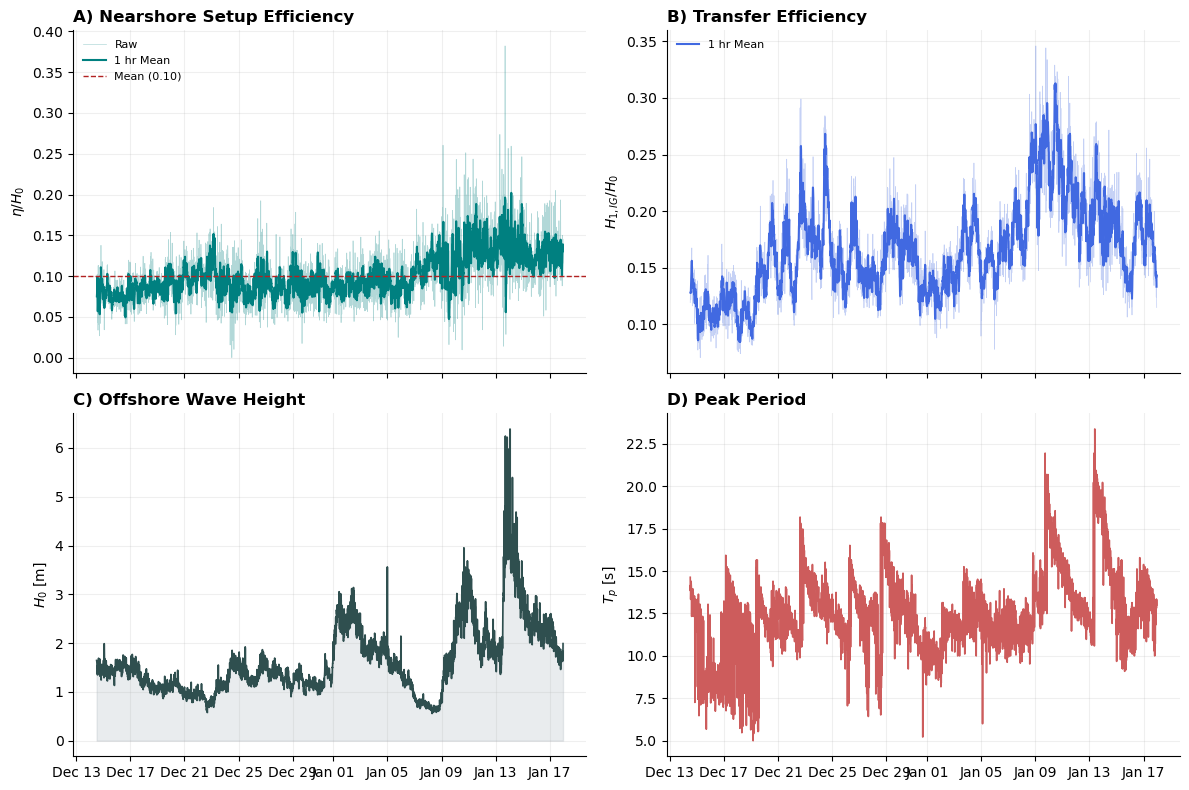

In [37]:


# Create 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True)

# Flatten or index into the 2D array:
# [0,0] = Top Left  | [0,1] = Top Right
# [1,0] = Bot Left  | [1,1] = Bot Right
ax1, ax2 = axes[0, 0], axes[0, 1]
ax3, ax4 = axes[1, 0], axes[1, 1]

# --- PANEL A: Setup Efficiency (Top Left) ---
ax1.plot(swell_event.index, swell_event['setup_efficiency'], 
         color='teal', lw=0.5, alpha=0.3, label='Raw')
ax1.plot(swell_event.index, swell_event['setup_smooth'], 
         color='teal', lw=1.5, label='1 hr Mean')
ax1.axhline(swell_event['setup_efficiency'].mean(), color='firebrick', 
            ls='--', lw=1, label=f"Mean ({swell_event['setup_efficiency'].mean():.2f})")
ax1.set_ylabel(r'$\eta / H_0$')
ax1.set_title('A) Nearshore Setup Efficiency', loc='left', fontweight='bold')

# --- PANEL B: Transfer Efficiency (Top Right) ---
ax2.plot(swell_event.index, swell_event['transfer_efficiency'], 
         color='royalblue', lw=0.5, alpha=0.3)
ax2.plot(swell_event.index, swell_event['transfer_smooth'], 
         color='royalblue', lw=1.5, label='1 hr Mean')
ax2.set_ylabel('$H_{1,IG} / H_0$')
ax2.set_title('B) Transfer Efficiency', loc='left', fontweight='bold')

# --- PANEL C: Wave Height (Bottom Left) ---
ax3.fill_between(swell_event.index, swell_event['H0'], color='slategray', alpha=0.15)
ax3.plot(swell_event.index, swell_event['H0'], color='darkslategrey', lw=1.2)
ax3.set_ylabel('$H_0$ [m]')
ax3.set_title('C) Offshore Wave Height', loc='left', fontweight='bold')

# --- PANEL D: Peak Period (Bottom Right) ---
ax4.plot(swell_event.index, swell_event['Tp'], color='indianred', lw=1.2)
ax4.set_ylabel('$T_p$ [s]')
ax4.set_title('D) Peak Period', loc='left', fontweight='bold')

# --- Global Refinement ---
for ax in axes.flat:
    ax.grid(True, linestyle='-', alpha=0.2)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.legend(frameon=False, loc='upper left', fontsize=8)
    # Ensure both bottom plots show dates since sharex=True only 
    # automatically handles the bottom-most row in a single column
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))

plt.tight_layout()
plt.show()

In [ ]:
7500/12

625.0